In [29]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage  

In [41]:
from dotenv import load_dotenv
load_dotenv()

True

In [42]:
generate_llm = GoogleGenerativeAI(model="gemini-1.5-pro")
evaluate_llm = GoogleGenerativeAI(model="gemini-1.5-pro")
optimizer_llm = GoogleGenerativeAI(model="gemini-1.5-pro")

In [32]:
class PostCreationState(TypedDict):
    topic : str
    content : str
    evaluation : Literal["good", "bad"]
    feedback : str
    iteration: int
    max_iterations: int

In [33]:
def generate(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

            Rules:
            - Do NOT use question-answer format.
            - Max 280 characters.
            - Use observational humor, irony, sarcasm, or cultural references.
            - Think in meme logic, punchlines, or relatable takes.
            - Use simple, day to day english.
            """)]
    
    response = generate_llm.invoke(messages)
    state['content'] = response
    return state

In [34]:
def evaluate(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a social media expert."),
        HumanMessage(content=f"""
            Evaluate the following tweet for humor and engagement:
            "{state['content']}"

            Rules:
            - Rate as "good" or "bad".
            - Provide constructive feedback.
            """)]
    
    response = evaluate_llm.invoke(messages)
    state['evaluation'] = response
    state['feedback'] = response
    return state

In [35]:
def optimize(state: PostCreationState) -> PostCreationState:
    messages = [
        SystemMessage(content="You are a social media optimization expert."),
        HumanMessage(content=f"""
            Optimize the following tweet based on feedback:
            "{state['content']}"
            Feedback: "{state['feedback']}"

            Rules:
            - Make it more engaging and humorous.
            - Keep it under 280 characters.
            """)]
    
    response = optimizer_llm.invoke(messages)
    state['content'] = response
    
    if state['evaluation'] == "good" or state['iteration'] >= state['max_iterations']:
        return END(state)
    
    state['iteration'] += 1
    return state

In [36]:
def route_evaluation(state: PostCreationState):
    if state['evaluation'] == "good":
        return 'exit'
    else:
        return 'try_again'

In [37]:
graph = StateGraph(PostCreationState)

graph.add_node("generate", generate)
graph.add_node("evaluate", evaluate)
graph.add_node("optimize", optimize)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", route_evaluation, {'exit': END, 'try_again': "optimize"})
graph.add_edge("optimize", "evaluate")

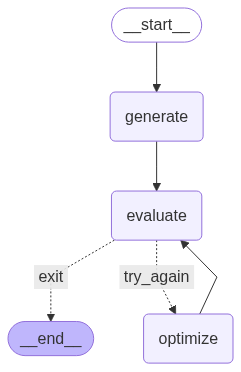

In [38]:
workflow = graph.compile()
workflow

In [39]:
init_state = {
    'topic' : "AI in bihar",
    'iteration' : 1,
    'max_iterations': 3   
}

In [43]:
result = workflow.invoke(init_state)


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API Key not found. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API Key not found. Please pass a valid API key."
]